In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
# sys.path.append('../../sportran/')
import sportran as st

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from scipy.interpolate import CubicSpline
def model(x, y):
    return CubicSpline(np.concatenate([-x[::-1], x[1:]]), np.concatenate([y[::-1], y[1:]]))

def model_wishart(x, y):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    y00, y01, y11 = y.reshape(3,l)
    yy = np.array([[y00, y01], [y01, y11]]).T
    # yy = np.einsum('tab,tbc->tac', np.transpose(yy, axes=(0,2,1)), yy)
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

In [6]:
dc=np.load('data/bayesian/CsF/dc_minimal.npy', allow_pickle=True).item()

# TODO: Laplace approximation around the maximum likelihood --> Hessian --> Covariance matrix --> Standard error on the mean

In [966]:
import opt_einsum

In [1056]:
LOG2=np.log(2)
from scipy.special import multigammaln
multig = multigammaln(0.5*3, 2)
def log_likelihood_wishart(w, model, omega, omega_fixed, data_, nu, ell):
        '''
        Logarithm of the Wishart probability density function.
        '''        
        n = ell
        p = 2

        # Compute scale matrix from the model (symmetrize to ensure positive definiteness)
        spline = model(omega_fixed, w)
        V = spline(omega)
        V = opt_einsum.contract('wba,wbc->wac', V, V) / n # equiv to V.T@V for each frequency

        # The argument of the PDF is the data
        X = data_ 
        
        # Determinant of X
        a, b, d = X[...,0,0], X[...,0,1], X[...,1,1]
        detX = a*d - b**2
        
        # Determinant and inverse of V
        a, b, d = V[...,0,0], V[...,0,1], V[...,1,1]
        invV = (1/(a*d - b**2)*np.array([[d, -b],[-b, a]])).transpose(2,0,1)
        detV = a*d - b**2

        # Trace of the matrix product between the inverse of V and X
        trinvV_X = opt_einsum.contract('wab,wba->w', invV, X)

        # if detV.min() < 0 or detX.min() < 0:
        #         print(detV.min(), detX.min())

        # Sum pieces of the log-likelihood
        log_pdf = 0.5*(-n*p*LOG2 - n*np.log(detV) + (n-p-1)*np.log(detX) - trinvV_X) - multig
        
        return np.sum(log_pdf)

def log_likelihood_offdiag(w, model, omega, omega_fixed, data_, nu, ell):
        '''
        Logarithm of the Variance-Gamma probability density function.
        '''
        import scipy.special as sp
        spline = model(omega_fixed, w)
        rho = np.clip(spline(omega), -0.98, 0.98)
        _alpha = 1/(1-rho**2)
        _beta = rho/(1-rho**2)
        _lambda = 0.5*ell*nu
        _gamma2 = np.abs(_alpha**2 - _beta**2)
        _lambda_minus_half = _lambda-0.5

        # Data is distributed according to a Variance-Gamma distribution with parameters (notation as in Wikipedia):
        # mu = 0; alpha = 1/(1-rho**2); beta = rho/(1-rho**2); lambda = ell*nu/2
        # Its expectation value is ell*nu*rho
        z = data_*ell*nu
        absz = np.abs(z)
        # z = data 
        # print([np.sum(i) for i in [_lambda*np.log(_gamma2), _lambda_minus_half*np.log(absz), 
        #       np.log(np.abs(sp.kv(_lambda_minus_half, _alpha*absz))), _beta*z,
        #        0.5*np.log(np.pi), np.log(sp.gamma(_lambda)), _lambda_minus_half*np.log(2*_alpha)]])

        print('1',np.min(_lambda_minus_half))
        print('2',np.min(_alpha*absz))
        print('3',np.min(sp.kv(_lambda_minus_half, _alpha*absz)))


        log_pdf = _lambda*np.log(_gamma2) + _lambda_minus_half*np.log(absz) + np.log(np.abs(sp.kv(_lambda_minus_half, _alpha*absz))) + \
                _beta*z - 0.5*np.log(np.pi) - np.log(sp.gamma(_lambda)) - _lambda_minus_half*np.log(2*_alpha)

        res = np.sum(log_pdf)
        return res

def log_likelihood_diag(w, model, omega, omega_fixed, data_,  ell):
        spline = model(omega_fixed, w)
        rho = np.clip(spline(omega), 1e-6, 1e6)

        # Data is distributed according to a Chi-squared distribution with parameters (notation as in Wikipedia):
        # Its expectation value is ell*rho
        z = data_*ell/rho
        absz = np.abs(z)
        # z = data 
        log_pdf = (ell / 2 - 1)*np.log(absz) - absz/2 - np.log(rho)

        res = np.sum(log_pdf)
        return res + log_prior_diag(w)

def log_prior_diag(w):
        # Uniform prior
        if np.all((w>=1e-6)&(w<=1e6)):
                return 1
        else:
                return -np.inf

In [1057]:
import scipy.optimize as opt

def do_mle(data_, w0, model, omega, omega_fixed, nu=2, ell=3, solver = 'CG'):    
    res = opt.minimize(fun = lambda w, model, omega, omega_fixed, data_, nu, ell: -log_likelihood_wishart(w, model, omega, omega_fixed, data_, nu, ell),
                       x0 = w0,  
                       args = (model, omega, omega_fixed, data_, nu, ell),
                       method = solver)
    params = res.x  
    return params

def do_mle_od(data_, w0, model, omega, omega_fixed, nu=2, ell=3, solver = 'CG'):    
    res = opt.minimize(fun = lambda w, model, omega, omega_fixed, data_, nu, ell: -log_likelihood_offdiag(w, model, omega, omega_fixed, data_, nu, ell),
                       x0 = w0,  
                       args = (model, omega, omega_fixed, data_, nu, ell),
                       method = solver)
    params = res.x   
    return params

def do_mle_d(data_, w0, model, omega, omega_fixed, ell=3, solver = 'CG'):    
    res = opt.minimize(fun = lambda w, model, omega, omega_fixed, data_, ell: -log_likelihood_diag(w, model, omega, omega_fixed, data_, ell),
                       x0 = w0,  
                       args = (model, omega, omega_fixed, data_, ell),
                       method = solver, tol = 1e-10, jac = '3-point')
    params = res.x  
    return params

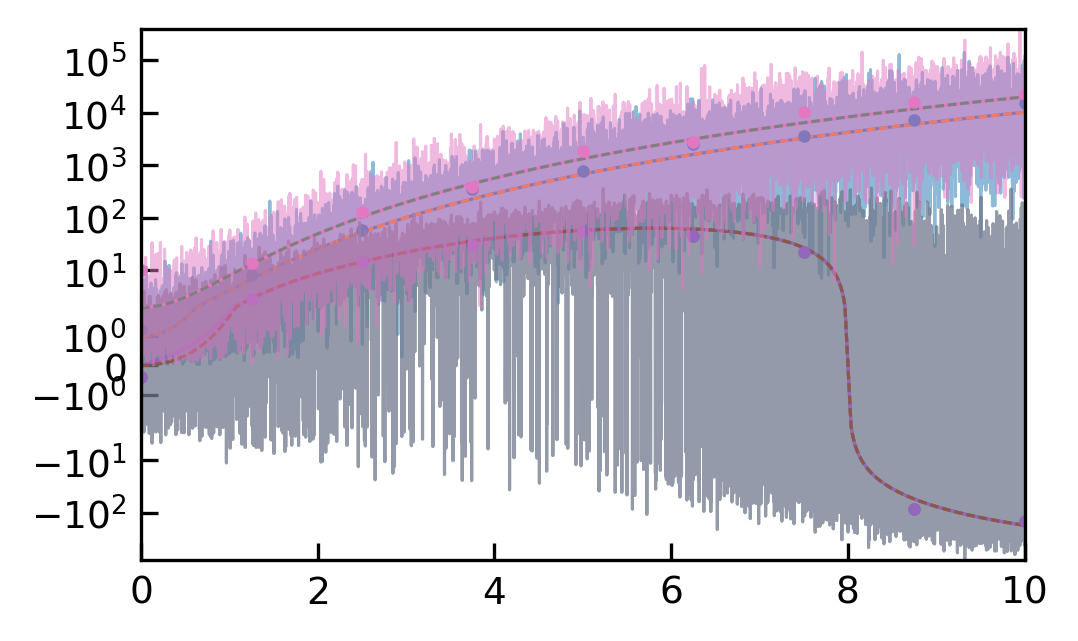

In [1058]:
npar = 9
nsam = 10000

omega = np.linspace(0, 10, nsam, endpoint=True)
omega_fixed = np.linspace(0, 10, npar, endpoint=True)
w0 = np.random.randn(npar*3)

diag = np.abs(omega**2) + 1
off_diag = np.sin(2*np.pi*omega/16)

diag_noise = np.random.chisquare(df = 6, size = diag.shape)/6
diag_noise2 = np.random.chisquare(df = 6, size = diag.shape)/6
off_diag_noise = 0.5*np.random.normal(size=off_diag.shape)

truth = np.array([diag, off_diag, off_diag, diag*1.4]).T.reshape(nsam,2,2)
truth = opt_einsum.contract('tba,tbc->tac', truth, truth)

data_ = np.array([diag*diag_noise, off_diag + off_diag_noise, off_diag + off_diag_noise, diag*1.4*diag_noise2]).T.reshape(nsam,2,2)
data_ = opt_einsum.contract('tba,tbc->tac', data_, data_)

guess = np.transpose(np.array([[pd.Series(data_[:,i,j]).rolling(window=50,closed='left',min_periods=0).mean().to_numpy() for i in range(2)] for j in range(2)]), axes = (2,0,1))
guess[0]=guess[1]
guess = np.array([guess[j] for j in [np.argmin(np.abs(omega-omega_fixed[i])) for i in range(len(omega_fixed))]])

assert np.min(np.linalg.det(data_)) > 0

true_params = np.array([np.abs(omega_fixed**2) + 1, 
                        np.sin(2*np.pi*omega_fixed/16), 
                        np.sin(2*np.pi*omega_fixed/16), 
                        (np.abs(omega_fixed**2) + 1)*1.4]).T.reshape(omega_fixed.size,2,2)
# true_params = opt_einsum.contract('tba,tbc->tac', true_params, true_params)
true_params = np.concatenate([true_params[:,0,0], true_params[:,0,1], true_params[:,1,1]])
# data_ = np.array([np.sin(2*np.pi*omega/4),np.sin(2*np.pi*omega*2/4),np.sin(2*np.pi*omega*1.5/4),np.sin(2*np.pi*omega*3/4)]).T.reshape(nsam,2,2) + np.random.randn(nsam, 2, 2)

true_spline = model_wishart(omega_fixed, true_params)
splined_y = true_spline(omega)
splined_y = opt_einsum.contract('tba,tbc->tac', splined_y, splined_y)

fig, ax = plt.subplots()

for i in range(2):
    for j in range(2):
        pl, = ax.plot(omega, data_[:,i,j], alpha = 0.5)
        ax.plot(omega, truth[:,i,j], color = pl.get_color(), markeredgecolor='black', markeredgewidth=0.5)
        ax.plot(omega, splined_y[:,i,j], ls = '--')
        # ax.plot(omega, true_spline(omega)[:,i,j], ls = '--')
        ax.plot(omega_fixed, guess[:,i,j], 'o', color = pl.get_color())
ax.set_yscale('symlog')

In [1059]:
params = do_mle(data_, true_params, model_wishart, omega, omega_fixed, solver = 'Nelder-Mead')
# params = do_mle(data_, true_params + np.random.normal(scale=3, size=true_params.shape), model_wishart, omega, omega_fixed, solver = 'CG')
# guess = np.concatenate([guess[:,0,0], guess[:,0,1], guess[:,1,1]])
# params = do_mle(data_, guess, model_wishart, omega, omega_fixed, solver = 'CG')

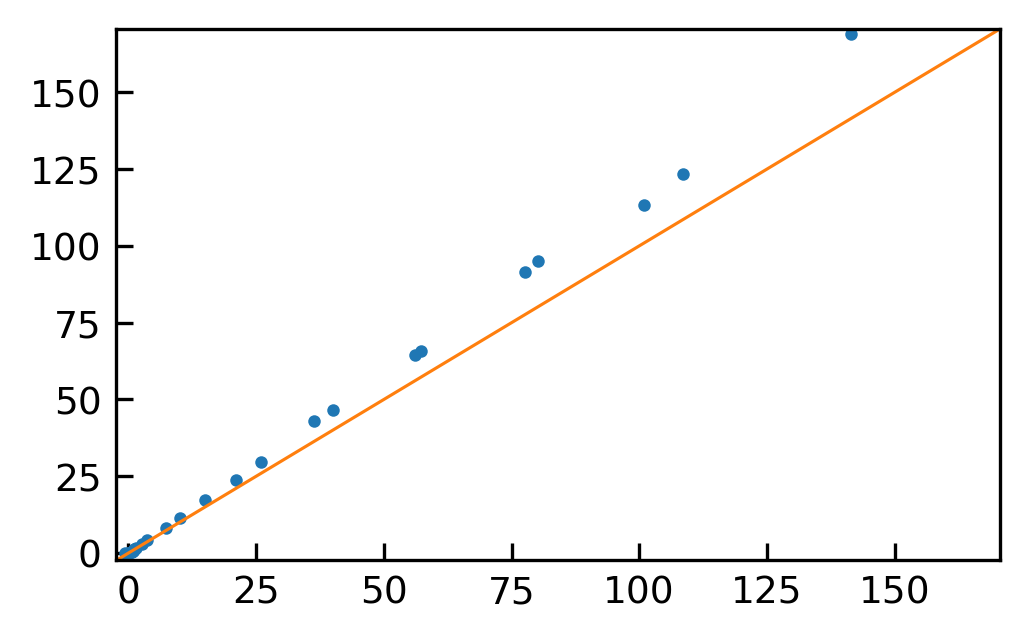

In [1060]:
plt.plot(true_params,params, 'o')
xmin, xmax = np.min(np.concatenate([true_params,params])), np.max(np.concatenate([true_params,params]))
delt = 0.01*(xmax-xmin)
plt.plot([xmin - delt,xmax + delt], [xmin - delt,xmax + delt])
# plt.ylim(xmin,xmax)
# plt.plot([-1000,200],[-1000,200])

In [1061]:
-log_likelihood_wishart(params, model_wishart, omega, omega_fixed, data_, 2, 3)

215703.2291812817

In [1062]:
-log_likelihood_wishart(true_params, model_wishart, omega, omega_fixed, data_, 2, 3)

217194.2018930231

# It makes sense that I am not getting to the `true_params`: the `-log_likelihood` is not minimal! TODO: fix this bug. The loglike must be minimal at the true parameters

## Capire dove cacchio va messo $\ell$ per far quadrare i conti

## Implementare l'informazione di Fisher: https://stats.stackexchange.com/questions/249078/what-is-the-fishers-information-matrix-for-the-wishart-distribution

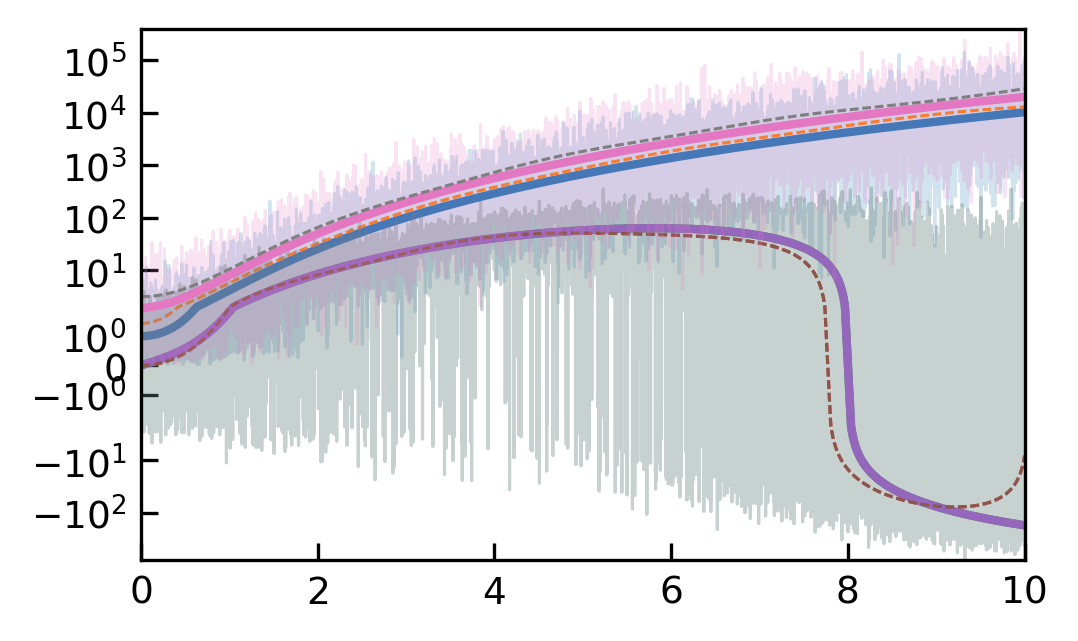

In [1064]:
opt_spline = model_wishart(omega_fixed, params)
th = opt_spline(omega)
th = opt_einsum.contract('tba,tbc->tac', th, th)

fig, ax = plt.subplots()
for i in range(2):
    for j in range(2):
        pl, = ax.plot(omega, data_[:, i,j], alpha = 0.2)
        pl, = ax.plot(omega, truth[:, i,j], alpha = 1, color = pl.get_color(), lw = 2)
        ax.plot(omega, th[:, i,j], alpha = 1, ls = '--')
ax.set_yscale('symlog')

In [ ]:
npar = 5
nsam = 1000

omega = np.linspace(0.1, 10, nsam, endpoint=True)
omega_fixed = np.linspace(0.1, 10, npar, endpoint=True)

truth = np.abs(omega**2) + 1
true_params = np.abs(omega_fixed**2) + 1
noise = np.random.chisquare(df=6, size=truth.shape)/6
data_ = truth*noise

w0 = true_params + np.random.normal(size=true_params.shape)*0.05

In [ ]:
params_od = do_mle_od(data_, w0, model_od, omega, omega_fixed, solver='CG')

1 2.5
2 22.18117431901184
3 0.0
1 2.5
2 22.18117431901184
3 0.0
1 2.5
2 22.18117431901184
3 0.0
1 2.5
2 22.18117431901184
3 0.0
1 2.5
2 22.18117431901184
3 0.0
1 2.5
2 22.18117431901184
3 0.0


/var/folders/1h/l4hl5gdn4j55pcw3tbrrx2c80000gn/T/ipykernel_33834/4079297062.py:57: RuntimeWarning: divide by zero encountered in log
  log_pdf = _lambda*np.log(_gamma2) + _lambda_minus_half*np.log(absz) + np.log(np.abs(sp.kv(_lambda_minus_half, _alpha*absz))) + \
/Users/paolo/micromamba/envs/lammps/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [ ]:
params_od, true_params

(array([  1.06441419,   7.68272051,  26.51352885,  57.61680625,
        100.95297957]),
 array([  1.01    ,   7.630625,  26.5025  ,  57.625625, 101.      ]))

(0.0, 300.0)

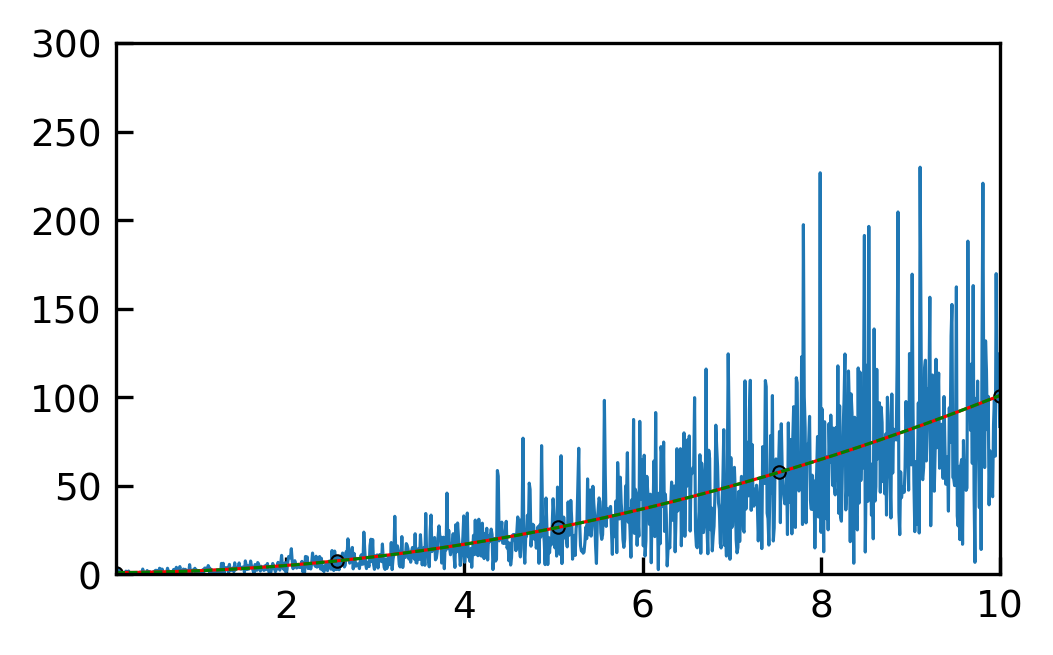

In [ ]:
fig, ax = plt.subplots()

pl, = ax.plot(omega, data_)
ax.plot(omega_fixed, true_params, 'o', color = pl.get_color(), markeredgecolor='black', markeredgewidth=0.5)
spl = model_od(omega_fixed, params_od)
ax.plot(omega, spl(omega), c = 'red')
spl = model_od(omega_fixed, true_params)
ax.plot(omega, spl(omega), c = 'green', ls = '--')

ax.set_ylim(0,300)

In [ ]:
true_params

array([  0.  ,   6.25,  25.  ,  56.25, 100.  ])

In [7]:
flux=st.HeatCurrent([(dc['qflux']), (dc['ele_flux'])],
                      DT_FS=1,
                      TEMPERATURE=dc['Temeprature'],
                      VOLUME=dc['Volume'],
                      UNITS='metal'
                     )

Using multicomponent code.


In [8]:
flux_resample=flux.resample(fstar_THz=20)

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      20.00000 THz
 Sampling time         TSKIP =            25 steps
                             =        25.000 fs
 Original  n. of frequencies =        100001
 Resampled n. of frequencies =          4001
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00018
 % of original PSD Power f<f* (pre-filter&sample)  = 99.707 %
 fPSD not calculated before resampling
 -----------------------------------------------------



In [12]:
flux_resample.bayesian_analysis(model, 4, n_steps = 10000, burn_in = 0)

You must install the tqdm library to use progress indicators with emcee


MCMC with 4 parameters and 8 walkers
Running up to 10000 steps
[45.52486617 35.7572916  41.62978853 51.13327919]
[55.47486796 35.31634649 52.96643866 55.05730845]
[57.27564388 47.7028527  62.21841209 61.9089177 ]
[59.42962059 48.70385826 59.03486027 58.49996813]
MCMC autocorrelation time = [61.70592068 55.98921351 56.47722514 65.94391729]
MCMC burn in = 395; thin = 83
-----------------------------------------------------
  BAYESIAN ANALYSIS
-----------------------------------------------------
  L_01   =           0.000303 +/-   0.000016
-----------------------------------------------------



In [16]:
chain = flux_resample.bayes.sampler.chain

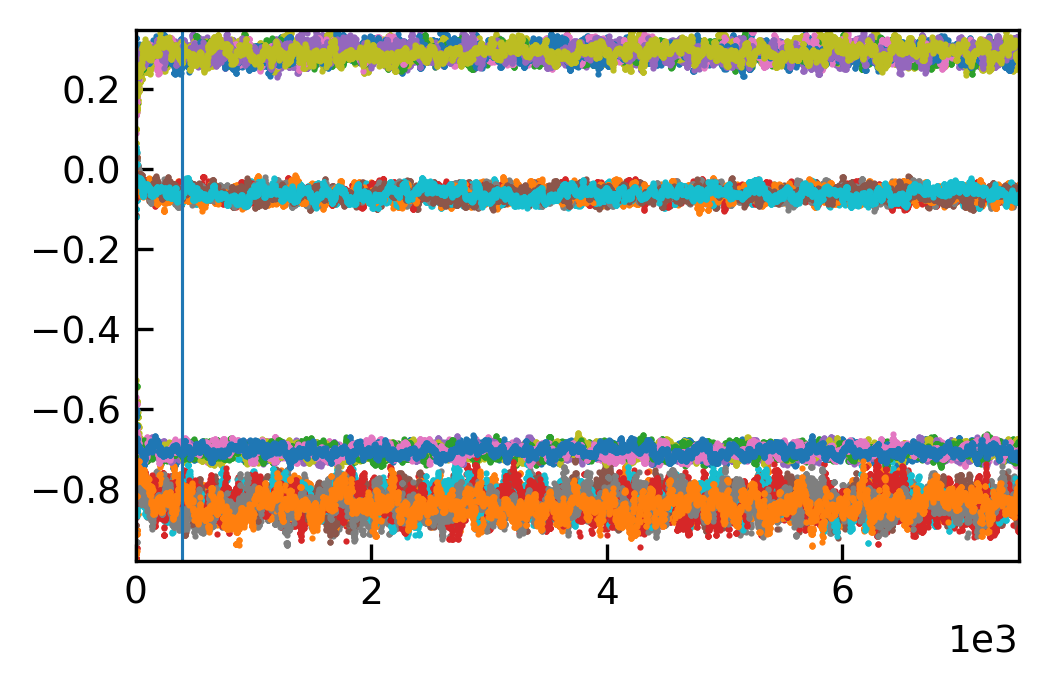

In [25]:
for x in chain:
    plt.plot(x[:,0], '.')
    plt.plot(x[:,1], '.')
    plt.plot(x[:,2], '.')
    plt.plot(x[:,3], '.')
plt.axvline(395)
# plt.xscale('log')

In [9]:
flux_resample.bayesian_analysis(model, 6, log_like='off')
bay=flux_resample.bayes

You must install the tqdm library to use progress indicators with emcee


MCMC with 6 parameters and 16 walkers
Running up to 2000000 steps
emcee: Exception while calling your likelihood function:
  params: [ 0.18021792  0.24366431 -0.26732124 -0.59426797 -0.85500721 -0.85363719]
  args: (array([   0,    1,    2, ..., 3998, 3999, 4000]), array([   0,  800, 1600, 2400, 3200, 4000]), array([ 0.04921777,  0.44522278,  1.13556658, ..., -1.0155539 ,
       -0.45174781, -0.39013564]), 2, 3)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/paolo/micromamba/envs/lammps/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paolo/Software/sportran_bayes/sportran/md/bayes.py", line 717, in log_posterior_offdiag
    return self.log_prior_offdiag(w) + self.log_likelihood_offdiag(w, omega, omega_fixed, data, nu, ell)
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paolo/Software/sportran_bayes/sportran/md/bayes.py", line 671, in log_likelihood_offdiag
    log_pdf = _lambda*np.log(_gamma2) + _lambda_minus_half*np.log(absz) + np.log(sp.kv(_lambda_minus_half, _alpha*absz)) + \
                                                                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [1]:
bay

NameError: name 'bay' is not defined

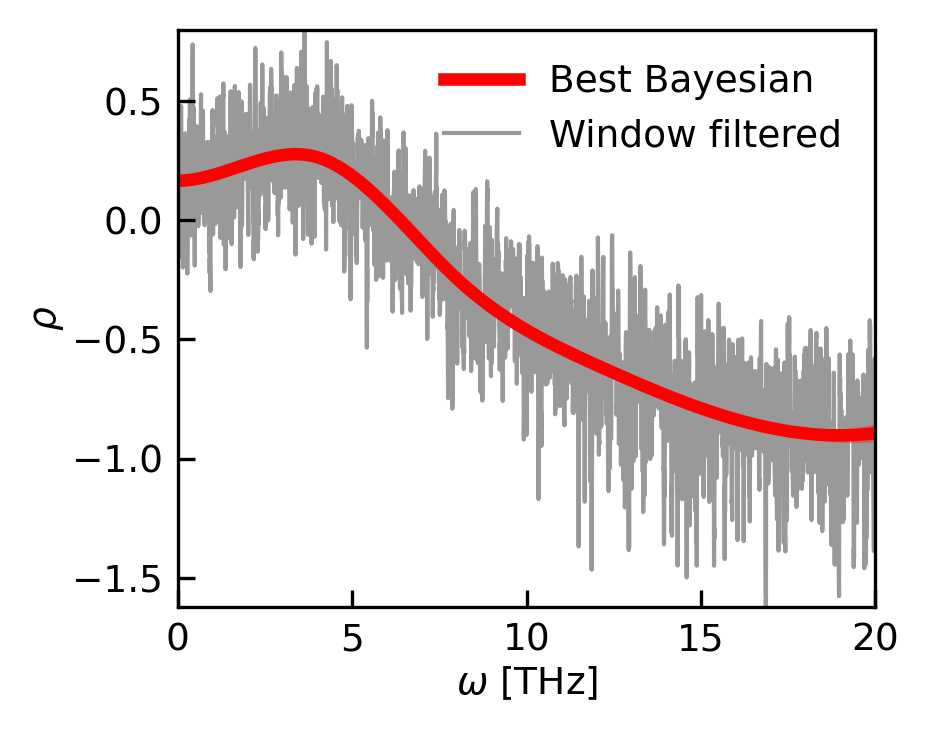

In [12]:
s=bay.omega[-1]/flux_resample.freqs_THz[-1]
cubic_mean_spline=bay.model(bay.omega_fixed, bay.parameters_mean)
cubic_max_spline=bay.model(bay.omega_fixed, bay.parameters_mean+bay.parameters_std)
cubic_min_spline=bay.model(bay.omega_fixed, bay.parameters_mean-bay.parameters_std)
f, ax=plt.subplots(figsize=[3,2.5])
ax.plot(flux_resample.freqs_THz, cubic_mean_spline(bay.omega), color='red', label='Best Bayesian',
        linewidth=3, zorder=1)
ax.fill_between(flux_resample.freqs_THz, 
                cubic_max_spline(bay.omega), cubic_min_spline(bay.omega), color='red', alpha=0.3, zorder=1)
Nf=5
ax.plot(flux_resample.freqs_THz, st.md.tools.filter.runavefilter(bay.noisy_data, Nf),
        linewidth=1, color='black', zorder=0,
        label='Window filtered', alpha=0.4)
ax.set_xlabel(r'$\omega$ [THz]')
ax.set_ylabel(r'$\rho$')
plt.legend(loc='best', fancybox=True, framealpha=0.0)

In [ ]:
sdata=np.loadtxt('data/bayesian/mock_data/mock_data_sin.dat').T

s_noise=sdata[1, 1:]*np.ones((2,2,(sdata[1,1:]).shape[0]))
true_s=(np.sin(sdata[0]/2.2 - np.pi/4)*0.98 + np.sin(-sdata[0]/2.2 - np.pi/4)*0.98)/2

In [ ]:
sdata[1, ].shape

(4001,)

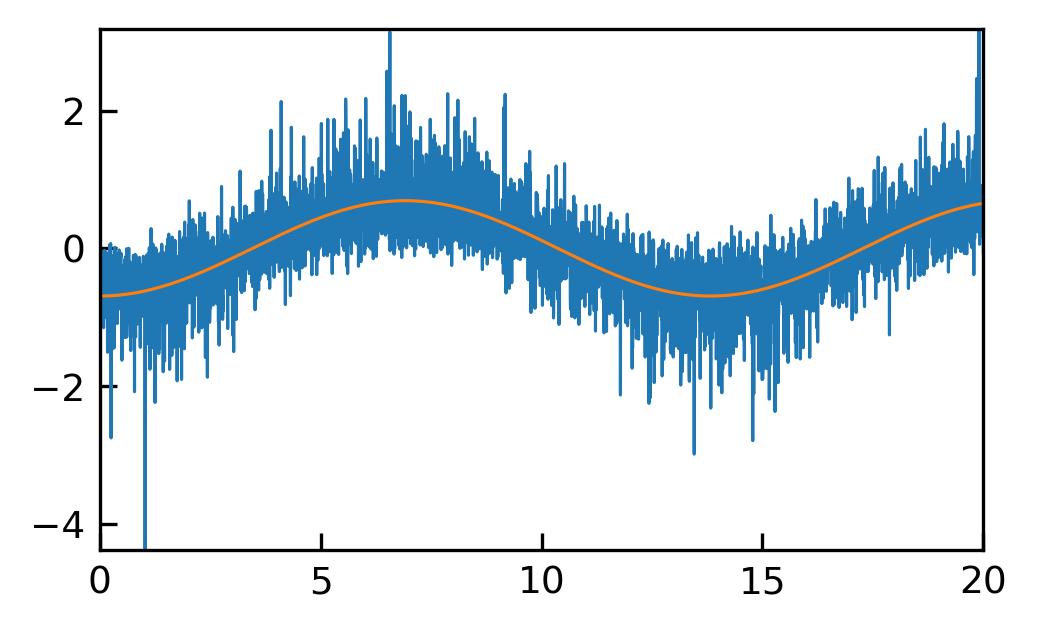

In [ ]:
plt.plot(sdata[0],sdata[1])
plt.plot(sdata[0],true_s)

In [ ]:
npr=8
bay=st.md.bayes.BayesFilter((s_noise[:,:,:])*3,model,n_parameters=npr, n_components=3)

bay.run_mcmc_scratch(n_parameters=npr,
             n_steps=2000000,
             is_restart=False,
             mask=None,
             filename='chain_sin_{}.h5'.format(npr),
             n_walkers=None,
             log_like='off')


  0%|          | 0/2000000 [00:00<?, ?it/s]/Users/enricodrigo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 5/2000000 [00:00<13:35:21, 40.88it/s]

MCMC with 8 parameters and 16 walkers
Running up to 2000000 steps


  0%|          | 1005/2000000 [00:23<13:03:38, 42.52it/s]

[52.52052256 45.29009383 46.06495915 39.15516239 31.32441985 43.18288245
 39.75463365 42.24679089]


  0%|          | 2000/2000000 [00:46<13:00:10, 42.68it/s]

[59.93213359 64.39415448 61.3360152  72.8807202  44.65552738 60.20953229
 62.27225641 72.11608274]


  0%|          | 3000/2000000 [01:10<12:57:59, 42.78it/s]

[63.48797952 73.40219032 68.21241101 79.33816729 58.44895418 62.61355588
 75.09302373 90.79058931]


  0%|          | 4000/2000000 [01:35<13:05:01, 42.38it/s]

[ 67.89079957  74.00902168  86.91704156  83.82339647  74.79126866
  72.23661195  82.98389665 103.42432584]


  0%|          | 5000/2000000 [02:00<12:50:28, 43.16it/s]

[ 70.02579636  82.52547107  87.88187256  93.60501833  77.50394872
  83.04917987  81.42823692 110.87267164]


  0%|          | 6005/2000000 [02:25<15:10:46, 36.49it/s]

[ 86.88981206  86.5459709  107.47736025 100.562028    93.82918505
 107.33162043 110.88082035 101.28398463]


  0%|          | 7005/2000000 [02:48<15:11:42, 36.43it/s]

[ 82.08140325 101.42590051  99.41576366 106.71939166 103.50220326
 110.11573001 105.94016955 109.31752572]


  0%|          | 8005/2000000 [03:12<15:15:36, 36.26it/s]

[ 84.22420095  94.75212313  99.3201634  104.97825411 100.86375138
 112.89598529 109.49118536 104.49414648]


  0%|          | 9005/2000000 [03:36<15:23:41, 35.92it/s]

[ 87.31856378 100.55528496 108.54280858  95.34413573 106.62617805
 111.39837253 116.66214893 107.45528937]


  0%|          | 10000/2000000 [04:00<12:53:28, 42.88it/s]

[ 94.94666575 101.09596165 113.93457187  94.49916734 105.08628408
 111.52025455 126.01107395 108.57378042]


  1%|          | 11000/2000000 [04:24<13:04:13, 42.27it/s]

[101.05536735 102.13101542 113.2559194   96.74134884 104.27528048
 107.78577403 122.23352706 113.48545363]


  1%|          | 12000/2000000 [04:48<13:04:45, 42.22it/s]

[103.13952734 100.06935884 118.82605796 100.19908656 107.07361816
 104.29966163 120.46947372 118.85606441]


  1%|          | 12250/2000000 [04:54<13:17:06, 41.56it/s]


900  discard
MCMC autocorrelation time = [103.67815919 102.95652762 119.76512969 100.52440087 108.18139875
 104.50237345 121.36627086 118.64874278]
MCMC burn in = 900; thin = 150


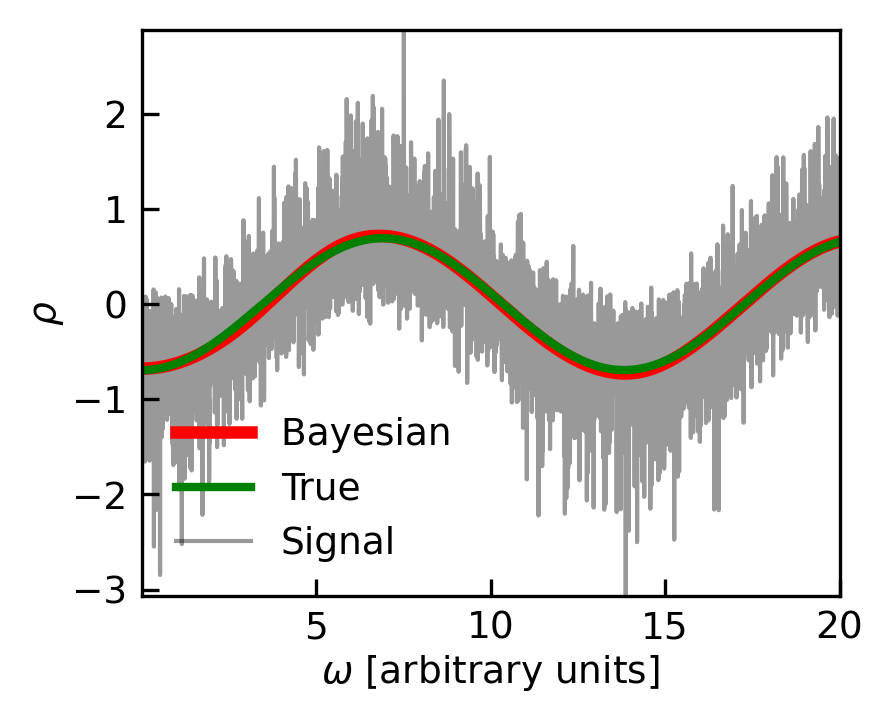

In [ ]:
s=bay.omega[-1]/sdata[0,-1]
cubic_mean_spline=bay.model(bay.omega_fixed, bay.parameters_mean)
cubic_max_spline=bay.model(bay.omega_fixed, bay.parameters_mean+bay.parameters_std)
cubic_min_spline=bay.model(bay.omega_fixed, bay.parameters_mean-bay.parameters_std)
f, ax=plt.subplots(figsize=[3,2.5])
ax.plot(sdata[0][1:], cubic_mean_spline(bay.omega), color='red', label='Bayesian ',
        linewidth=3, zorder=1)
ax.plot(sdata[0][1:], true_s[1:], color='green', label='True',
        linewidth=2, zorder=1)
ax.fill_between(sdata[0][1:], 
                cubic_max_spline(bay.omega), cubic_min_spline(bay.omega), color='red', alpha=0.3, zorder=1)
Nf=0
ax.plot(sdata[0][1:], st.md.tools.filter.runavefilter(bay.noisy_data, Nf),
        linewidth=1, color='black', zorder=0,
        label='Signal', alpha=0.4)
ax.set_xlabel(r'$\omega$ [arbitrary units]')
ax.set_ylabel(r'$\rho$')
plt.legend(loc='best', fancybox=True, framealpha=0.0)